# 0. Load Package(s)

In [43]:
from __future__ import annotations
import os, json, warnings, contextlib, re, glob
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import yaml
import torch
import xgboost as xgb
from packaging import version as _ver
from sklearn.metrics import (
    precision_recall_fscore_support, 
    roc_auc_score, 
    average_precision_score, 
    mean_absolute_percentage_error, 
    mean_squared_error
)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.cloud import bigquery
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from evidently import Dataset, DataDefinition, Report, Regression
from evidently.presets import DataDriftPreset, RegressionPreset
from evidently.ui.workspace import CloudWorkspace

# 1-1. Modeling using Original Test Data

Configuration:
- BQ Project: baserock-student
- Prices Table: baserock-student.coinbase_dataset.btc_prices
- Tweets Table: baserock-student.twitter_dataset.bitcoin_tweets
- Default Frequency: 15min
- Lookback Days: 20
BITCOIN PRICE PREDICTION BACKTEST PIPELINE

1. Loading 24 days of data (train: 20, test: 3)...
Loading 24 days of price data...
Loaded 1484 price points at 15min frequency
Train period: 2025-08-05 17:00:00+00:00 to 2025-08-18 13:45:00+00:00
Test period: 2025-08-18 14:00:00+00:00 to 2025-08-21 03:45:00+00:00
Train points: 1236, Test points: 248

2. Loading tweet data...
Loading tweets from 2025-08-05 17:00:00+00:00 to 2025-08-21 03:45:00+00:00...
Loaded 4311 tweets

3. Setting up model parameters...

4. Training ARIMA model on training data...

5. Engineering tweet sentiment features...
Processing 4291 tweets for sentiment analysis...
Loading FinBERT on cuda...
Feature columns: ['tweet_count', 'sentiment_pos_mean', 'sentiment_neg_mean', 'sentiment_neu_mean', 'sentiment_com

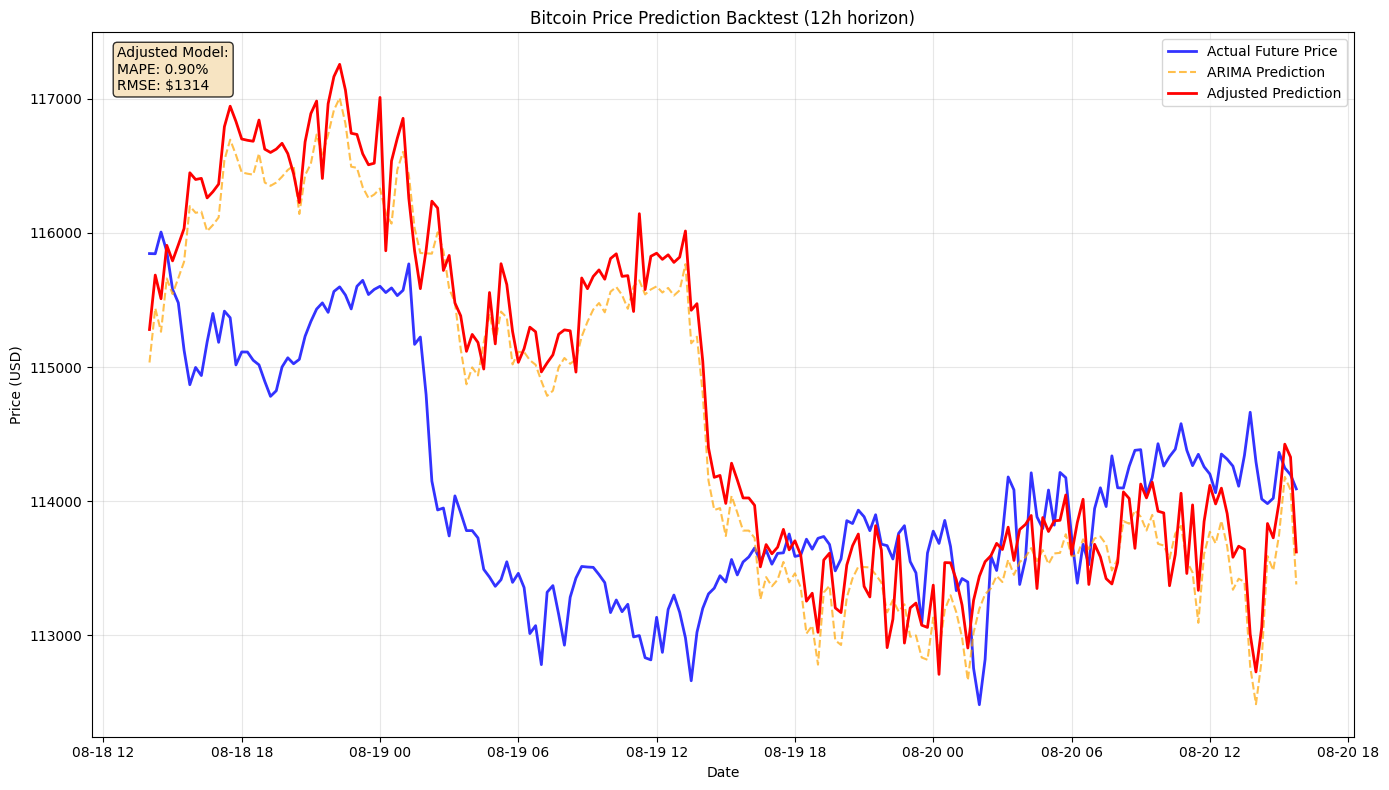


11. Uploading results to Evidently Cloud...
Uploaded Bitcoin model to Evidently Cloud: Bitcoin_ARIMA_XGBoost_Original_Data

Backtest pipeline completed successfully!
Results stored in 'backtest_results' dictionary.


In [44]:
BQ_PROJECT = os.getenv("BQ_PROJECT", "baserock-student")
BQ_PRICES_TABLE = os.getenv("BQ_PRICES_TABLE", "baserock-student.coinbase_dataset.btc_prices")
BQ_TWEETS_TABLE = os.getenv("BQ_TWEETS_TABLE", "baserock-student.twitter_dataset.bitcoin_tweets")

DEFAULT_LOOKBACK_DAYS = int(os.getenv("LOOKBACK_DAYS", "20"))
DEFAULT_FREQ = os.getenv("BRANCHB_FREQ", "15min")

_FINBERT = {"tok": None, "model": None, "device": None}
TWEET_TIME_COL = "created_at"

EVIDENTLY_TOKEN = "dG9rbgE8LE4A9ZxCEJ8mpR+NZQFVV0Cb2p7aTU3DIOJpFWBeZwBQQYQOKxGn8nXPklkjVAjBYm6weDejz6QENxbdoSJ9hem84Wct+xUl3b6B/SCUxi9NsunlogeRJJo0F8czzH619ivGLAZ/z7lUGjWi8nCp7RL/tQDD"
EVIDENTLY_PROJECT_ID = "0198c4bb-4ffc-76c7-b0ea-f6e381026dff"

print(f"Configuration:")
print(f"- BQ Project: {BQ_PROJECT}")
print(f"- Prices Table: {BQ_PRICES_TABLE}")
print(f"- Tweets Table: {BQ_TWEETS_TABLE or 'Not set'}")
print(f"- Default Frequency: {DEFAULT_FREQ}")
print(f"- Lookback Days: {DEFAULT_LOOKBACK_DAYS}")

def _clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = re.sub(r"https?://\S+", "", s).replace("&amp;", "&")
    return re.sub(r"\s+", " ", s).strip()

def get_finbert(device: str | None = None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if _FINBERT["tok"] is None or _FINBERT["device"] != device:
        print(f"Loading FinBERT on {device}...")
        tok = AutoTokenizer.from_pretrained("ProsusAI/finbert", use_fast=False)
        mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device).eval()
        _FINBERT.update({"tok": tok, "model": mdl, "device": device})
    return _FINBERT["tok"], _FINBERT["model"], _FINBERT["device"]

def finbert_sentiment_df(texts: List[str], batch_size=64, max_length=96, device=None) -> pd.DataFrame:
    if not texts:
        return pd.DataFrame(columns=["negative","neutral","positive","compound","label"])
    
    tok, mdl, device = get_finbert(device)
    probs = []
    with torch.no_grad():
        ctx = torch.amp.autocast("cuda") if device == "cuda" else contextlib.nullcontext()
        with ctx:
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                logits = mdl(**enc).logits
                p = torch.softmax(logits, dim=-1).detach().cpu().numpy()
                probs.append(p)
    p = np.vstack(probs) if probs else np.zeros((0, 3))
    cols = ["negative","neutral","positive"]
    df = pd.DataFrame(p, columns=cols)
    for want in cols:
        if want not in df.columns: df[want] = 0.0
    df["compound"] = df["positive"] - df["negative"]
    df["label"] = df[["negative","neutral","positive"]].idxmax(axis=1)
    return df[["negative","neutral","positive","compound","label"]]

def engineer_tweet_features_window(tweets_df: pd.DataFrame, freq=DEFAULT_FREQ, tweet_time_col=TWEET_TIME_COL) -> pd.DataFrame:
    if tweets_df.empty:
        return pd.DataFrame(columns=[
            "bin_start","tweet_count",
            "sentiment_pos_mean","sentiment_neg_mean","sentiment_neu_mean","sentiment_compound_mean",
            "sentiment_compound_max","sentiment_compound_min",
            "sentiment_pos_sum","sentiment_neg_sum",
        ])
    tw = tweets_df.copy()
    tw[tweet_time_col] = pd.to_datetime(tw[tweet_time_col], utc=True, errors="coerce")
    tw = tw.dropna(subset=[tweet_time_col])
    tw["text"] = tw["text"].astype(str).map(_clean_text)
    tw = tw[tw["text"].str.len() > 0].reset_index(drop=True)

    print(f"Processing {len(tw)} tweets for sentiment analysis...")
    sent = finbert_sentiment_df(tw["text"].tolist(), batch_size=64, max_length=96)
    tw = pd.concat([tw.reset_index(drop=True), sent.reset_index(drop=True)], axis=1)

    tw["bin_start"] = tw[tweet_time_col].dt.floor(freq)
    agg = tw.groupby("bin_start").agg(
        tweet_count=("text","count"),
        sentiment_pos_mean=("positive","mean"),
        sentiment_neg_mean=("negative","mean"),
        sentiment_neu_mean=("neutral","mean"),
        sentiment_compound_mean=("compound","mean"),
        sentiment_compound_max=("compound","max"),
        sentiment_compound_min=("compound","min"),
        sentiment_pos_sum=("positive","sum"),
        sentiment_neg_sum=("negative","sum"),
    ).reset_index()
    return agg.sort_values("bin_start").reset_index(drop=True)

def add_bull_target(df: pd.DataFrame, time_col: str, price_col: str,
                    horizon_hours=12, pad_minutes=30, thresh=0.008) -> pd.DataFrame:
    out = df.copy()

    t = pd.to_datetime(out[time_col], utc=True, errors="coerce")
    out[time_col] = t.dt.tz_convert("UTC").dt.tz_localize(None)
    out = out.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

    price_df = out[[time_col, price_col]].dropna().rename(columns={time_col: "t", price_col: "close_now"})
    price_df["t_future"] = price_df["t"] + pd.Timedelta(hours=horizon_hours)

    price_df["t"] = pd.to_datetime(price_df["t"]).astype("datetime64[ns]")
    price_df["t_future"] = pd.to_datetime(price_df["t_future"]).astype("datetime64[ns]")

    future = pd.merge_asof(
        price_df[["t_future"]],
        price_df[["t", "close_now"]].rename(columns={"t": "t_match", "close_now": "close_future"}),
        left_on="t_future", right_on="t_match", direction="backward"
    )

    price_df["close_future"] = future["close_future"].values
    price_df["fwd_ret"] = (price_df["close_future"] - price_df["close_now"]) / price_df["close_now"]
    price_df["bull_start"] = (price_df["fwd_ret"] >= thresh).fillna(False)

    out["bull_run_12h"] = 0
    if price_df["bull_start"].any():
        pad = pd.Timedelta(minutes=pad_minutes)
        bull_times = price_df.loc[price_df["bull_start"], "t"].to_numpy()
        t_series = out[time_col]
        for t0 in bull_times:
            mask = (t_series >= (t0 - pad)) & (t_series <= (t0 + pad))
            out.loc[mask, "bull_run_12h"] = 1
    return out

def _xgb_kwargs_for_device():
    args = {}
    if _ver.parse(xgb.__version__) >= _ver.parse("2.0.0"):
        args["tree_method"] = "hist"
        args["device"] = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        args["tree_method"] = "gpu_hist" if torch.cuda.is_available() else "hist"
    return args

def choose_f1_threshold(y_true: np.ndarray, proba: np.ndarray) -> float:
    if len(np.unique(y_true)) < 2:
        return 0.5
    thr = np.linspace(0.0, 1.0, 101)
    best_f1, best_t = -1.0, 0.5
    for t in thr:
        pred = (proba >= t).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t)

def calculate_performance_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        return {"MAPE": np.nan, "RMSE": np.nan}
    
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean) * 100
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    
    return {
        "MAPE": mape,
        "RMSE": rmse,
        "Data_Points": len(y_true_clean)
    }

def bq_client() -> bigquery.Client:
    return bigquery.Client(project=BQ_PROJECT)

def load_prices_lookback(days: int = DEFAULT_LOOKBACK_DAYS, freq=DEFAULT_FREQ) -> pd.DataFrame:
    client = bq_client()
    q = f"""
    SELECT timestamp, close
    FROM `{BQ_PRICES_TABLE}`
    WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {days} DAY)
    ORDER BY timestamp
    """
    print(f"Loading {days} days of price data...")
    df = client.query(q).to_dataframe()
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df = (df.set_index("timestamp")
            .resample(freq).last().dropna().reset_index())
    print(f"Loaded {len(df)} price points at {freq} frequency")
    return df.rename(columns={"timestamp":"date"})

def load_tweets_window(start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> pd.DataFrame:
    if not BQ_TWEETS_TABLE:
        print("No tweets table configured, returning empty DataFrame")
        return pd.DataFrame(columns=["created_at","text"])
    
    client = bq_client()
    q = f"""
    SELECT created_at, text
    FROM `{BQ_TWEETS_TABLE}`
    WHERE created_at BETWEEN @start AND @end
    ORDER BY created_at
    """
    print(f"Loading tweets from {start_ts} to {end_ts}...")
    job = client.query(q, job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("start", "TIMESTAMP", start_ts.to_pydatetime()),
            bigquery.ScalarQueryParameter("end", "TIMESTAMP", end_ts.to_pydatetime()),
        ]
    ))
    df = job.to_dataframe()
    if df.empty:
        print("No tweets found in the specified time range")
        return pd.DataFrame(columns=["created_at","text"])
    df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
    print(f"Loaded {len(df)} tweets")
    return df

def upload_bitcoin_model_to_evidently(backtest_df: pd.DataFrame, feat_cols: List[str], run_name: str):
    ws = CloudWorkspace(
        token=EVIDENTLY_TOKEN,
        url="https://app.evidently.cloud"
    )
    
    project = ws.get_project(EVIDENTLY_PROJECT_ID)
    
    model_df = backtest_df.copy()
    model_df["target"] = model_df["actual_future"]
    model_df["prediction"] = model_df["adjusted_pred"]
    
    feature_columns = ["current_price", "bull_prob", "adj_factor"] + feat_cols
    for col in feature_columns:
        if col not in model_df.columns:
            model_df[col] = 0.0
    
    schema = DataDefinition(
        numerical_columns=feature_columns,
        regression=[Regression(target="target", prediction="prediction")]
    )
    
    current = Dataset.from_pandas(model_df, data_definition=schema)
    
    report = Report([RegressionPreset()])
    my_eval = report.run(current_data=current, tags=[run_name])
    
    ws.add_run(project.id, my_eval, include_data=False)
    print(f"Uploaded Bitcoin model to Evidently Cloud: {run_name}")

def upload_data_drift_to_evidently(original_features: pd.DataFrame, modified_features: pd.DataFrame, feat_cols: List[str], run_name: str):
    ws = CloudWorkspace(
        token=EVIDENTLY_TOKEN,
        url="https://app.evidently.cloud"
    )
    
    project = ws.get_project(EVIDENTLY_PROJECT_ID)
    
    schema = DataDefinition(numerical_columns=feat_cols)
    
    eval_data_ref = Dataset.from_pandas(original_features, data_definition=schema)
    eval_data_test = Dataset.from_pandas(modified_features, data_definition=schema)
    
    report = Report([DataDriftPreset()])
    my_eval = report.run(eval_data_test, eval_data_ref)
    
    ws.add_run(project.id, my_eval, include_data=False)
    print(f"Uploaded data drift to Evidently Cloud: {run_name}")

def run_bitcoin_backtest_pipeline(lookback_days: int = 20, 
                                 horizon_hours: int = 12,
                                 freq: str = "15min",
                                 alpha: float = 0.01,
                                 test_days: int = 2,
                                 plot_results: bool = True):

    print("="*80)
    print("BITCOIN PRICE PREDICTION BACKTEST PIPELINE")
    print("="*80)
    
    total_days = lookback_days + test_days + 1
    print(f"\n1. Loading {total_days} days of data (train: {lookback_days}, test: {test_days})...")
    
    all_prices = load_prices_lookback(days=total_days, freq=freq)
    
    if all_prices.empty or len(all_prices) < 200:
        raise ValueError("Not enough price data for backtesting")
    
    split_date = all_prices["date"].quantile(lookback_days / total_days)
    train_prices = all_prices[all_prices["date"] <= split_date].copy()
    test_prices = all_prices[all_prices["date"] > split_date].copy()
    
    print(f"Train period: {train_prices['date'].min()} to {train_prices['date'].max()}")
    print(f"Test period: {test_prices['date'].min()} to {test_prices['date'].max()}")
    print(f"Train points: {len(train_prices)}, Test points: {len(test_prices)}")
    
    print("\n2. Loading tweet data...")
    tweets = load_tweets_window(all_prices["date"].min(), all_prices["date"].max())
    
    print("\n3. Setting up model parameters...")
    params = {
        "p": 1, "d": 1, "q": 1,
        "max_depth": 4, "n_estimators": 300, "learning_rate": 0.05,
        "subsample": 0.9, "colsample_bytree": 0.9,
        "min_child_weight": 2, "gamma": 0.0,
        "reg_lambda": 2.0, "reg_alpha": 0.0,
    }
    
    print("\n4. Training ARIMA model on training data...")
    order = (int(params["p"]), int(params["d"]), int(params["q"]))
    
    print("\n5. Engineering tweet sentiment features...")
    tw_feats = engineer_tweet_features_window(tweets, freq=freq, tweet_time_col="created_at")
    
    train_df = train_prices.copy()
    train_df["bin_start"] = pd.to_datetime(train_df["date"], utc=True).dt.floor(freq)
    train_df = train_df.merge(tw_feats, on="bin_start", how="left")
    
    feat_cols = [c for c in train_df.columns if c.startswith(("tweet_count","sentiment_"))]
    for c in feat_cols:
        train_df[c] = train_df[c].fillna(0)
    
    print(f"Feature columns: {feat_cols}")
    
    print("\n6. Creating bull run targets for training...")
    train_df_lbl = add_bull_target(train_df.rename(columns={"date":"ts"}), time_col="ts", price_col="close",
                                  horizon_hours=horizon_hours, pad_minutes=30, thresh=0.008)
    
    X_train = train_df_lbl[feat_cols].copy()
    y_train = train_df_lbl["bull_run_12h"].astype(int).values
    base_rate = float(y_train.mean())
    
    print(f"Training bull run base rate: {base_rate:.3f}")
    
    xgb_model = None
    decision_threshold = 0.5
    
    if feat_cols and y_train.mean() not in (0.0, 1.0) and not X_train.empty:
        print("\n7. Training XGBoost classifier...")
        k = max(1, int(len(X_train) * 0.9))
        X_core, X_val = X_train.iloc[:k].copy(), X_train.iloc[k:].copy()
        y_core, y_val = y_train[:k], y_train[k:]
        spw = (1 - y_core.mean()) / (y_core.mean() + 1e-12)
        
        xgb_model = xgb.XGBClassifier(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            min_child_weight=int(params["min_child_weight"]),
            learning_rate=float(params["learning_rate"]),
            subsample=float(params["subsample"]),
            colsample_bytree=float(params["colsample_bytree"]),
            gamma=float(params["gamma"]),
            reg_lambda=float(params["reg_lambda"]),
            reg_alpha=float(params["reg_alpha"]),
            eval_metric="logloss",
            scale_pos_weight=spw,
            random_state=42,
            **_xgb_kwargs_for_device(),
        )
        
        xgb_model.fit(X_core, y_core, eval_set=[(X_core, y_core), (X_val, y_val)], verbose=False)
        
        val_prob = xgb_model.predict_proba(X_val)[:, 1]
        decision_threshold = choose_f1_threshold(y_val, val_prob)
        print(f"XGBoost trained, decision threshold: {decision_threshold:.3f}")
    else:
        print("Skipping XGBoost training (insufficient data or features)")
    
    print(f"\n8. Running backtest on {test_days} days of test data...")
    
    backtest_results = []
    
    for i in range(len(test_prices)):
        current_time = test_prices.iloc[i]["date"]
        current_price = test_prices.iloc[i]["close"]
        
        historical_data = pd.concat([
            train_prices,
            test_prices.iloc[:i+1]
        ]).reset_index(drop=True)
        
        if len(historical_data) < 50:
            continue
            
        arima_model = SARIMAX(historical_data["close"].astype(float), order=order,
                              enforce_stationarity=False, enforce_invertibility=False)
        try:
            arima_res = arima_model.fit(disp=False)
            steps = int((pd.Timedelta(hours=horizon_hours) / pd.Timedelta(freq)))
            arima_fc = arima_res.get_forecast(steps=steps)
            arima_pred = arima_fc.predicted_mean.iloc[-1]
        except:
            continue
        
        current_time_floor = pd.to_datetime(current_time, utc=True).floor(freq)
        tweet_features = tw_feats[tw_feats["bin_start"] == current_time_floor]
        
        if tweet_features.empty:
            feature_values = np.zeros(len(feat_cols))
        else:
            feature_values = tweet_features[feat_cols].iloc[0].values
        
        if xgb_model is not None and feat_cols:
            bull_prob = xgb_model.predict_proba([feature_values])[0, 1]
        else:
            bull_prob = base_rate
        
        adj_factor = 1.0 + alpha * (bull_prob - base_rate)
        adjusted_pred = arima_pred * adj_factor
        
        future_time = pd.to_datetime(current_time) + pd.Timedelta(hours=horizon_hours)
        future_prices = all_prices[all_prices["date"] >= future_time]
        if not future_prices.empty:
            actual_future_price = future_prices.iloc[0]["close"]
            
            backtest_results.append({
                "timestamp": current_time,
                "current_price": current_price,
                "arima_pred": arima_pred,
                "bull_prob": bull_prob,
                "adj_factor": adj_factor,
                "adjusted_pred": adjusted_pred,
                "actual_future": actual_future_price,
                "horizon_hours": horizon_hours
            })
    
    if not backtest_results:
        raise ValueError("No backtest results generated. Check data availability.")
    
    backtest_df = pd.DataFrame(backtest_results)
    
    print("\n9. Calculating performance metrics...")
    
    arima_metrics = calculate_performance_metrics(
        backtest_df["actual_future"].values,
        backtest_df["arima_pred"].values
    )
    
    adjusted_metrics = calculate_performance_metrics(
        backtest_df["actual_future"].values,
        backtest_df["adjusted_pred"].values
    )
    
    print("\n" + "="*80)
    print("BACKTEST RESULTS")
    print("="*80)
    
    print(f"\nBacktest Period: {horizon_hours}h forecasts on {len(backtest_df)} test points")
    print(f"Test Period: {backtest_df['timestamp'].min()} to {backtest_df['timestamp'].max()}")
    
    print(f"\nðŸ“Š ARIMA Model Performance:")
    print(f"  â€¢ MAPE: {arima_metrics['MAPE']:.2f}%")
    print(f"  â€¢ RMSE: ${arima_metrics['RMSE']:.2f}")
    
    print(f"\nðŸš€ Adjusted Model Performance:")
    print(f"  â€¢ MAPE: {adjusted_metrics['MAPE']:.2f}%")
    print(f"  â€¢ RMSE: ${adjusted_metrics['RMSE']:.2f}")
    
    improvement_mape = arima_metrics['MAPE'] - adjusted_metrics['MAPE']
    improvement_rmse = arima_metrics['RMSE'] - adjusted_metrics['RMSE']
    
    print(f"\nðŸ“ˆ Improvement:")
    print(f"  â€¢ MAPE: {improvement_mape:+.2f}% (lower is better)")
    print(f"  â€¢ RMSE: ${improvement_rmse:+.2f} (lower is better)")
    
    print(f"\nSample Predictions:")
    sample_df = backtest_df[["timestamp", "current_price", "arima_pred", "adjusted_pred", "actual_future"]].tail(10)
    sample_df["arima_error"] = abs(sample_df["actual_future"] - sample_df["arima_pred"])
    sample_df["adjusted_error"] = abs(sample_df["actual_future"] - sample_df["adjusted_pred"])
    sample_df = sample_df.round(2)
    print(sample_df.to_string(index=False))
    
    if plot_results:
        print(f"\n10. Creating backtest visualization...")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        
        ax.plot(backtest_df["timestamp"], backtest_df["actual_future"], 
                label="Actual Future Price", color="blue", linewidth=2, alpha=0.8)
        ax.plot(backtest_df["timestamp"], backtest_df["arima_pred"], 
                label="ARIMA Prediction", color="orange", linestyle="--", alpha=0.7)
        ax.plot(backtest_df["timestamp"], backtest_df["adjusted_pred"], 
                label="Adjusted Prediction", color="red", linewidth=2)
        
        ax.set_title(f"Bitcoin Price Prediction Backtest ({horizon_hours}h horizon)")
        ax.set_ylabel("Price (USD)")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        textstr = f'Adjusted Model:\nMAPE: {adjusted_metrics["MAPE"]:.2f}%\nRMSE: ${adjusted_metrics["RMSE"]:.0f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
    
    print("\n11. Uploading results to Evidently Cloud...")
    
    try:
        upload_bitcoin_model_to_evidently(
            backtest_df=backtest_df,
            feat_cols=feat_cols,
            run_name="Bitcoin_ARIMA_XGBoost_Original_Data"
        )
        
    except Exception as e:
        print(f"Error uploading to Evidently: {e}")
        print("Continuing with local results...")
    
    return {
        "backtest_df": backtest_df,
        "arima_metrics": arima_metrics,
        "adjusted_metrics": adjusted_metrics,
        "train_prices": train_prices,
        "test_prices": test_prices,
        "tweets": tweets,
        "xgb_model": xgb_model,
        "features": feat_cols,
        "base_rate": base_rate,
        "decision_threshold": decision_threshold,
        "alpha": alpha,
        "improvement_mape": improvement_mape,
        "improvement_rmse": improvement_rmse
    }

if __name__ == "__main__":
    backtest_results = run_bitcoin_backtest_pipeline(
        lookback_days=20,
        test_days=3,
        horizon_hours=12,
        freq="15min",
        alpha=0.01,
        plot_results=True
    )
    
    print("\nBacktest pipeline completed successfully!")
    print("Results stored in 'backtest_results' dictionary.")

# 1-2. Modeling using Changed Test Data (2 Features Changed)

Configuration:
- BQ Project: baserock-student
- Prices Table: baserock-student.coinbase_dataset.btc_prices
- Tweets Table: baserock-student.twitter_dataset.bitcoin_tweets
- Default Frequency: 15min
- Lookback Days: 20
BITCOIN PRICE PREDICTION BACKTEST PIPELINE

1. Loading 24 days of data (train: 20, test: 3)...
Loading 24 days of price data...
Loaded 1484 price points at 15min frequency
Train period: 2025-08-05 17:00:00+00:00 to 2025-08-18 13:45:00+00:00
Test period: 2025-08-18 14:00:00+00:00 to 2025-08-21 03:45:00+00:00
Train points: 1236, Test points: 248

2. Loading tweet data...
Loading tweets from 2025-08-05 17:00:00+00:00 to 2025-08-21 03:45:00+00:00...
Loaded 4311 tweets

3. Setting up model parameters...

4. Training ARIMA model on training data...

5. Engineering tweet sentiment features...
Processing 4291 tweets for sentiment analysis...
Loading FinBERT on cuda...
Feature columns: ['tweet_count', 'sentiment_pos_mean', 'sentiment_neg_mean', 'sentiment_neu_mean', 'sentiment_com

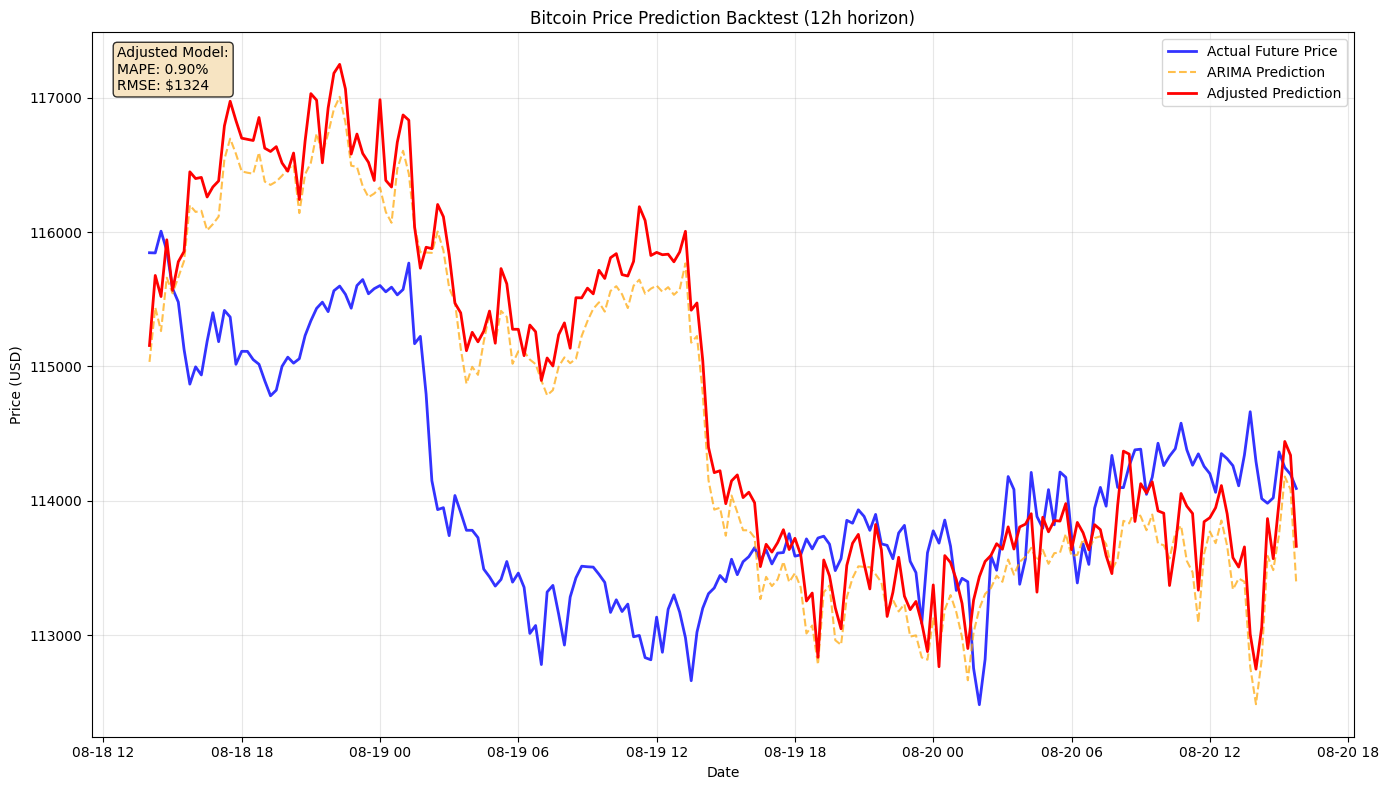


11. Uploading results to Evidently Cloud...
Uploaded Bitcoin model to Evidently Cloud: Bitcoin_ARIMA_XGBoost_Modified_Data

Backtest pipeline completed successfully!
Results stored in 'backtest_results' dictionary.


In [45]:

BQ_PROJECT = os.getenv("BQ_PROJECT", "baserock-student")
BQ_PRICES_TABLE = os.getenv("BQ_PRICES_TABLE", "baserock-student.coinbase_dataset.btc_prices")
BQ_TWEETS_TABLE = os.getenv("BQ_TWEETS_TABLE", "baserock-student.twitter_dataset.bitcoin_tweets")

DEFAULT_LOOKBACK_DAYS = int(os.getenv("LOOKBACK_DAYS", "20"))
DEFAULT_FREQ = os.getenv("BRANCHB_FREQ", "15min")

_FINBERT = {"tok": None, "model": None, "device": None}
TWEET_TIME_COL = "created_at"

EVIDENTLY_TOKEN = "dG9rbgE8LE4A9ZxCEJ8mpR+NZQFVV0Cb2p7aTU3DIOJpFWBeZwBQQYQOKxGn8nXPklkjVAjBYm6weDejz6QENxbdoSJ9hem84Wct+xUl3b6B/SCUxi9NsunlogeRJJo0F8czzH619ivGLAZ/z7lUGjWi8nCp7RL/tQDD"
EVIDENTLY_PROJECT_ID = "0198c4bb-4ffc-76c7-b0ea-f6e381026dff"

DEFAULT_LOOKBACK_DAYS = int(os.getenv("LOOKBACK_DAYS", "20"))
DEFAULT_FREQ = os.getenv("BRANCHB_FREQ", "15min")

_FINBERT = {"tok": None, "model": None, "device": None}
TWEET_TIME_COL = "created_at"

EVIDENTLY_TOKEN = "dG9rbgE8LE4A9ZxCEJ8mpR+NZQFVV0Cb2p7aTU3DIOJpFWBeZwBQQYQOKxGn8nXPklkjVAjBYm6weDejz6QENxbdoSJ9hem84Wct+xUl3b6B/SCUxi9NsunlogeRJJo0F8czzH619ivGLAZ/z7lUGjWi8nCp7RL/tQDD"
EVIDENTLY_PROJECT_ID = "0198c4bb-4ffc-76c7-b0ea-f6e381026dff"

print(f"Configuration:")
print(f"- BQ Project: {BQ_PROJECT}")
print(f"- Prices Table: {BQ_PRICES_TABLE}")
print(f"- Tweets Table: {BQ_TWEETS_TABLE or 'Not set'}")
print(f"- Default Frequency: {DEFAULT_FREQ}")
print(f"- Lookback Days: {DEFAULT_LOOKBACK_DAYS}")

def _clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = re.sub(r"https?://\S+", "", s).replace("&amp;", "&")
    return re.sub(r"\s+", " ", s).strip()

def get_finbert(device: str | None = None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if _FINBERT["tok"] is None or _FINBERT["device"] != device:
        print(f"Loading FinBERT on {device}...")
        tok = AutoTokenizer.from_pretrained("ProsusAI/finbert", use_fast=False)
        mdl = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device).eval()
        _FINBERT.update({"tok": tok, "model": mdl, "device": device})
    return _FINBERT["tok"], _FINBERT["model"], _FINBERT["device"]

def finbert_sentiment_df(texts: List[str], batch_size=64, max_length=96, device=None) -> pd.DataFrame:
    if not texts:
        return pd.DataFrame(columns=["negative","neutral","positive","compound","label"])
    
    tok, mdl, device = get_finbert(device)
    probs = []
    with torch.no_grad():
        ctx = torch.amp.autocast("cuda") if device == "cuda" else contextlib.nullcontext()
        with ctx:
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tok(batch, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
                enc = {k: v.to(device) for k, v in enc.items()}
                logits = mdl(**enc).logits
                p = torch.softmax(logits, dim=-1).detach().cpu().numpy()
                probs.append(p)
    p = np.vstack(probs) if probs else np.zeros((0, 3))
    cols = ["negative","neutral","positive"]
    df = pd.DataFrame(p, columns=cols)
    for want in cols:
        if want not in df.columns: df[want] = 0.0
    df["compound"] = df["positive"] - df["negative"]
    df["label"] = df[["negative","neutral","positive"]].idxmax(axis=1)
    return df[["negative","neutral","positive","compound","label"]]

def engineer_tweet_features_window(tweets_df: pd.DataFrame, freq=DEFAULT_FREQ, tweet_time_col=TWEET_TIME_COL) -> pd.DataFrame:
    if tweets_df.empty:
        return pd.DataFrame(columns=[
            "bin_start","tweet_count",
            "sentiment_pos_mean","sentiment_neg_mean","sentiment_neu_mean","sentiment_compound_mean",
            "sentiment_compound_max","sentiment_compound_min",
            "sentiment_pos_sum","sentiment_neg_sum",
        ])
    tw = tweets_df.copy()
    tw[tweet_time_col] = pd.to_datetime(tw[tweet_time_col], utc=True, errors="coerce")
    tw = tw.dropna(subset=[tweet_time_col])
    tw["text"] = tw["text"].astype(str).map(_clean_text)
    tw = tw[tw["text"].str.len() > 0].reset_index(drop=True)

    print(f"Processing {len(tw)} tweets for sentiment analysis...")
    sent = finbert_sentiment_df(tw["text"].tolist(), batch_size=64, max_length=96)
    tw = pd.concat([tw.reset_index(drop=True), sent.reset_index(drop=True)], axis=1)

    tw["bin_start"] = tw[tweet_time_col].dt.floor(freq)
    agg = tw.groupby("bin_start").agg(
        tweet_count=("text","count"),
        sentiment_pos_mean=("positive","mean"),
        sentiment_neg_mean=("negative","mean"),
        sentiment_neu_mean=("neutral","mean"),
        sentiment_compound_mean=("compound","mean"),
        sentiment_compound_max=("compound","max"),
        sentiment_compound_min=("compound","min"),
        sentiment_pos_sum=("positive","sum"),
        sentiment_neg_sum=("negative","sum"),
    ).reset_index()
    return agg.sort_values("bin_start").reset_index(drop=True)

def add_bull_target(df: pd.DataFrame, time_col: str, price_col: str,
                    horizon_hours=12, pad_minutes=30, thresh=0.008) -> pd.DataFrame:
    out = df.copy()

    t = pd.to_datetime(out[time_col], utc=True, errors="coerce")
    out[time_col] = t.dt.tz_convert("UTC").dt.tz_localize(None)
    out = out.dropna(subset=[time_col]).sort_values(time_col).reset_index(drop=True)

    price_df = out[[time_col, price_col]].dropna().rename(columns={time_col: "t", price_col: "close_now"})
    price_df["t_future"] = price_df["t"] + pd.Timedelta(hours=horizon_hours)

    price_df["t"] = pd.to_datetime(price_df["t"]).astype("datetime64[ns]")
    price_df["t_future"] = pd.to_datetime(price_df["t_future"]).astype("datetime64[ns]")

    future = pd.merge_asof(
        price_df[["t_future"]],
        price_df[["t", "close_now"]].rename(columns={"t": "t_match", "close_now": "close_future"}),
        left_on="t_future", right_on="t_match", direction="backward"
    )

    price_df["close_future"] = future["close_future"].values
    price_df["fwd_ret"] = (price_df["close_future"] - price_df["close_now"]) / price_df["close_now"]
    price_df["bull_start"] = (price_df["fwd_ret"] >= thresh).fillna(False)

    out["bull_run_12h"] = 0
    if price_df["bull_start"].any():
        pad = pd.Timedelta(minutes=pad_minutes)
        bull_times = price_df.loc[price_df["bull_start"], "t"].to_numpy()
        t_series = out[time_col]
        for t0 in bull_times:
            mask = (t_series >= (t0 - pad)) & (t_series <= (t0 + pad))
            out.loc[mask, "bull_run_12h"] = 1
    return out

def _xgb_kwargs_for_device():
    args = {}
    if _ver.parse(xgb.__version__) >= _ver.parse("2.0.0"):
        args["tree_method"] = "hist"
        args["device"] = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        args["tree_method"] = "gpu_hist" if torch.cuda.is_available() else "hist"
    return args

def choose_f1_threshold(y_true: np.ndarray, proba: np.ndarray) -> float:
    if len(np.unique(y_true)) < 2:
        return 0.5
    thr = np.linspace(0.0, 1.0, 101)
    best_f1, best_t = -1.0, 0.5
    for t in thr:
        pred = (proba >= t).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(y_true, pred, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t)

def calculate_performance_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        return {"MAPE": np.nan, "RMSE": np.nan}
    
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean) * 100
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    
    return {
        "MAPE": mape,
        "RMSE": rmse,
        "Data_Points": len(y_true_clean)
    }

def bq_client() -> bigquery.Client:
    return bigquery.Client(project=BQ_PROJECT)

def load_prices_lookback(days: int = DEFAULT_LOOKBACK_DAYS, freq=DEFAULT_FREQ) -> pd.DataFrame:
    client = bq_client()
    q = f"""
    SELECT timestamp, close
    FROM `{BQ_PRICES_TABLE}`
    WHERE timestamp >= TIMESTAMP_SUB(CURRENT_TIMESTAMP(), INTERVAL {days} DAY)
    ORDER BY timestamp
    """
    print(f"Loading {days} days of price data...")
    df = client.query(q).to_dataframe()
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
    df = (df.set_index("timestamp")
            .resample(freq).last().dropna().reset_index())
    print(f"Loaded {len(df)} price points at {freq} frequency")
    return df.rename(columns={"timestamp":"date"})

def load_tweets_window(start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> pd.DataFrame:
    if not BQ_TWEETS_TABLE:
        print("No tweets table configured, returning empty DataFrame")
        return pd.DataFrame(columns=["created_at","text"])
    
    client = bq_client()
    q = f"""
    SELECT created_at, text
    FROM `{BQ_TWEETS_TABLE}`
    WHERE created_at BETWEEN @start AND @end
    ORDER BY created_at
    """
    print(f"Loading tweets from {start_ts} to {end_ts}...")
    job = client.query(q, job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("start", "TIMESTAMP", start_ts.to_pydatetime()),
            bigquery.ScalarQueryParameter("end", "TIMESTAMP", end_ts.to_pydatetime()),
        ]
    ))
    df = job.to_dataframe()
    if df.empty:
        print("No tweets found in the specified time range")
        return pd.DataFrame(columns=["created_at","text"])
    df["created_at"] = pd.to_datetime(df["created_at"], utc=True)
    print(f"Loaded {len(df)} tweets")
    return df

def upload_bitcoin_model_to_evidently(backtest_df: pd.DataFrame, feat_cols: List[str], run_name: str):
    ws = CloudWorkspace(
        token=EVIDENTLY_TOKEN,
        url="https://app.evidently.cloud"
    )
    
    project = ws.get_project(EVIDENTLY_PROJECT_ID)
    
    model_df = backtest_df.copy()
    model_df["target"] = model_df["actual_future"]
    model_df["prediction"] = model_df["adjusted_pred"]
    
    feature_columns = ["current_price", "bull_prob", "adj_factor"] + feat_cols
    for col in feature_columns:
        if col not in model_df.columns:
            model_df[col] = 0.0
    
    schema = DataDefinition(
        numerical_columns=feature_columns,
        regression=[Regression(target="target", prediction="prediction")]
    )
    
    current = Dataset.from_pandas(model_df, data_definition=schema)
    
    report = Report([RegressionPreset()])
    my_eval = report.run(current_data=current, tags=[run_name])
    
    ws.add_run(project.id, my_eval, include_data=False)
    print(f"Uploaded Bitcoin model to Evidently Cloud: {run_name}")

def run_bitcoin_backtest_pipeline(lookback_days: int = 20, 
                                 horizon_hours: int = 12,
                                 freq: str = "15min",
                                 alpha: float = 0.01,
                                 test_days: int = 2,
                                 plot_results: bool = True):

    print("="*80)
    print("BITCOIN PRICE PREDICTION BACKTEST PIPELINE")
    print("="*80)
    
    total_days = lookback_days + test_days + 1
    print(f"\n1. Loading {total_days} days of data (train: {lookback_days}, test: {test_days})...")
    
    all_prices = load_prices_lookback(days=total_days, freq=freq)
    
    if all_prices.empty or len(all_prices) < 200:
        raise ValueError("Not enough price data for backtesting")
    
    split_date = all_prices["date"].quantile(lookback_days / total_days)
    train_prices = all_prices[all_prices["date"] <= split_date].copy()
    test_prices = all_prices[all_prices["date"] > split_date].copy()
    
    print(f"Train period: {train_prices['date'].min()} to {train_prices['date'].max()}")
    print(f"Test period: {test_prices['date'].min()} to {test_prices['date'].max()}")
    print(f"Train points: {len(train_prices)}, Test points: {len(test_prices)}")
    
    print("\n2. Loading tweet data...")
    tweets = load_tweets_window(all_prices["date"].min(), all_prices["date"].max())
    
    print("\n3. Setting up model parameters...")
    params = {
        "p": 1, "d": 1, "q": 1,
        "max_depth": 4, "n_estimators": 300, "learning_rate": 0.05,
        "subsample": 0.9, "colsample_bytree": 0.9,
        "min_child_weight": 2, "gamma": 0.0,
        "reg_lambda": 2.0, "reg_alpha": 0.0,
    }
    
    print("\n4. Training ARIMA model on training data...")
    order = (int(params["p"]), int(params["d"]), int(params["q"]))
    
    print("\n5. Engineering tweet sentiment features...")
    tw_feats = engineer_tweet_features_window(tweets, freq=freq, tweet_time_col="created_at")
    
    train_df = train_prices.copy()
    train_df["bin_start"] = pd.to_datetime(train_df["date"], utc=True).dt.floor(freq)
    train_df = train_df.merge(tw_feats, on="bin_start", how="left")
    
    feat_cols = [c for c in train_df.columns if c.startswith(("tweet_count","sentiment_"))]
    for c in feat_cols:
        train_df[c] = train_df[c].fillna(0)
    
    print(f"Feature columns: {feat_cols}")
    
    print("\n6. Creating bull run targets for training...")
    train_df_lbl = add_bull_target(train_df.rename(columns={"date":"ts"}), time_col="ts", price_col="close",
                                  horizon_hours=horizon_hours, pad_minutes=30, thresh=0.008)
    
    X_train = train_df_lbl[feat_cols].copy()
    y_train = train_df_lbl["bull_run_12h"].astype(int).values
    base_rate = float(y_train.mean())
    
    print(f"Training bull run base rate: {base_rate:.3f}")
    
    xgb_model = None
    decision_threshold = 0.5
    
    if feat_cols and y_train.mean() not in (0.0, 1.0) and not X_train.empty:
        print("\n7. Training XGBoost classifier...")
        k = max(1, int(len(X_train) * 0.9))
        X_core, X_val = X_train.iloc[:k].copy(), X_train.iloc[k:].copy()
        y_core, y_val = y_train[:k], y_train[k:]
        spw = (1 - y_core.mean()) / (y_core.mean() + 1e-12)
        
        xgb_model = xgb.XGBClassifier(
            n_estimators=int(params["n_estimators"]),
            max_depth=int(params["max_depth"]),
            min_child_weight=int(params["min_child_weight"]),
            learning_rate=float(params["learning_rate"]),
            subsample=float(params["subsample"]),
            colsample_bytree=float(params["colsample_bytree"]),
            gamma=float(params["gamma"]),
            reg_lambda=float(params["reg_lambda"]),
            reg_alpha=float(params["reg_alpha"]),
            eval_metric="logloss",
            scale_pos_weight=spw,
            random_state=42,
            **_xgb_kwargs_for_device(),
        )
        
        xgb_model.fit(X_core, y_core, eval_set=[(X_core, y_core), (X_val, y_val)], verbose=False)
        
        val_prob = xgb_model.predict_proba(X_val)[:, 1]
        decision_threshold = choose_f1_threshold(y_val, val_prob)
        print(f"XGBoost trained, decision threshold: {decision_threshold:.3f}")
    else:
        print("Skipping XGBoost training (insufficient data or features)")
    
    print(f"\n8. Running backtest on {test_days} days of test data...")
    
    backtest_results = []
    
    for i in range(len(test_prices)):
        current_time = test_prices.iloc[i]["date"]
        current_price = test_prices.iloc[i]["close"]
        
        historical_data = pd.concat([
            train_prices,
            test_prices.iloc[:i+1]
        ]).reset_index(drop=True)
        
        if len(historical_data) < 50:
            continue
            
        arima_model = SARIMAX(historical_data["close"].astype(float), order=order,
                              enforce_stationarity=False, enforce_invertibility=False)
        try:
            arima_res = arima_model.fit(disp=False)
            steps = int((pd.Timedelta(hours=horizon_hours) / pd.Timedelta(freq)))
            arima_fc = arima_res.get_forecast(steps=steps)
            arima_pred = arima_fc.predicted_mean.iloc[-1]
        except:
            continue
        
        current_time_floor = pd.to_datetime(current_time, utc=True).floor(freq)
        tweet_features = tw_feats[tw_feats["bin_start"] == current_time_floor]
        
        if tweet_features.empty:
            feature_values = np.zeros(len(feat_cols))
        else:
            feature_values = tweet_features[feat_cols].iloc[0].values
        
        if len(feat_cols) >= 2:
            feature_values[0] = np.random.uniform(0, 1)
            feature_values[1] = np.random.uniform(0, 1)
        
        if xgb_model is not None and feat_cols:
            bull_prob = xgb_model.predict_proba([feature_values])[0, 1]
        else:
            bull_prob = base_rate
        
        adj_factor = 1.0 + alpha * (bull_prob - base_rate)
        adjusted_pred = arima_pred * adj_factor
        
        future_time = pd.to_datetime(current_time) + pd.Timedelta(hours=horizon_hours)
        future_prices = all_prices[all_prices["date"] >= future_time]
        if not future_prices.empty:
            actual_future_price = future_prices.iloc[0]["close"]
            
            backtest_results.append({
                "timestamp": current_time,
                "current_price": current_price,
                "arima_pred": arima_pred,
                "bull_prob": bull_prob,
                "adj_factor": adj_factor,
                "adjusted_pred": adjusted_pred,
                "actual_future": actual_future_price,
                "horizon_hours": horizon_hours
            })
    
    if not backtest_results:
        raise ValueError("No backtest results generated. Check data availability.")
    
    backtest_df = pd.DataFrame(backtest_results)
    
    print("\n9. Calculating performance metrics...")
    
    arima_metrics = calculate_performance_metrics(
        backtest_df["actual_future"].values,
        backtest_df["arima_pred"].values
    )
    
    adjusted_metrics = calculate_performance_metrics(
        backtest_df["actual_future"].values,
        backtest_df["adjusted_pred"].values
    )
    
    print("\n" + "="*80)
    print("BACKTEST RESULTS")
    print("="*80)
    
    print(f"\nBacktest Period: {horizon_hours}h forecasts on {len(backtest_df)} test points")
    print(f"Test Period: {backtest_df['timestamp'].min()} to {backtest_df['timestamp'].max()}")
    
    print(f"\nðŸ“Š ARIMA Model Performance:")
    print(f"  â€¢ MAPE: {arima_metrics['MAPE']:.2f}%")
    print(f"  â€¢ RMSE: ${arima_metrics['RMSE']:.2f}")
    
    print(f"\nðŸš€ Adjusted Model Performance:")
    print(f"  â€¢ MAPE: {adjusted_metrics['MAPE']:.2f}%")
    print(f"  â€¢ RMSE: ${adjusted_metrics['RMSE']:.2f}")
    
    improvement_mape = arima_metrics['MAPE'] - adjusted_metrics['MAPE']
    improvement_rmse = arima_metrics['RMSE'] - adjusted_metrics['RMSE']
    
    print(f"\nðŸ“ˆ Improvement:")
    print(f"  â€¢ MAPE: {improvement_mape:+.2f}% (lower is better)")
    print(f"  â€¢ RMSE: ${improvement_rmse:+.2f} (lower is better)")
    
    print(f"\nSample Predictions:")
    sample_df = backtest_df[["timestamp", "current_price", "arima_pred", "adjusted_pred", "actual_future"]].tail(10)
    sample_df["arima_error"] = abs(sample_df["actual_future"] - sample_df["arima_pred"])
    sample_df["adjusted_error"] = abs(sample_df["actual_future"] - sample_df["adjusted_pred"])
    sample_df = sample_df.round(2)
    print(sample_df.to_string(index=False))
    
    if plot_results:
        print(f"\n10. Creating backtest visualization...")
        
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        
        ax.plot(backtest_df["timestamp"], backtest_df["actual_future"], 
                label="Actual Future Price", color="blue", linewidth=2, alpha=0.8)
        ax.plot(backtest_df["timestamp"], backtest_df["arima_pred"], 
                label="ARIMA Prediction", color="orange", linestyle="--", alpha=0.7)
        ax.plot(backtest_df["timestamp"], backtest_df["adjusted_pred"], 
                label="Adjusted Prediction", color="red", linewidth=2)
        
        ax.set_title(f"Bitcoin Price Prediction Backtest ({horizon_hours}h horizon)")
        ax.set_ylabel("Price (USD)")
        ax.set_xlabel("Date")
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        textstr = f'Adjusted Model:\nMAPE: {adjusted_metrics["MAPE"]:.2f}%\nRMSE: ${adjusted_metrics["RMSE"]:.0f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        plt.show()
    
    print("\n11. Uploading results to Evidently Cloud...")
    
    try:
        upload_bitcoin_model_to_evidently(
            backtest_df=backtest_df,
            feat_cols=feat_cols,
            run_name="Bitcoin_ARIMA_XGBoost_Modified_Data"
        )
        
    except Exception as e:
        print(f"Error uploading to Evidently: {e}")
        print("Continuing with local results...")
    
    return {
        "backtest_df": backtest_df,
        "arima_metrics": arima_metrics,
        "adjusted_metrics": adjusted_metrics,
        "train_prices": train_prices,
        "test_prices": test_prices,
        "tweets": tweets,
        "xgb_model": xgb_model,
        "features": feat_cols,
        "base_rate": base_rate,
        "decision_threshold": decision_threshold,
        "alpha": alpha,
        "improvement_mape": improvement_mape,
        "improvement_rmse": improvement_rmse
    }

if __name__ == "__main__":
    backtest_results = run_bitcoin_backtest_pipeline(
        lookback_days=20,
        test_days=3,
        horizon_hours=12,
        freq="15min",
        alpha=0.01,
        plot_results=True
    )
    
    print("\nBacktest pipeline completed successfully!")
    print("Results stored in 'backtest_results' dictionary.")

# Appendix

In [ ]:
# This can be edited to fit our needs

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from evidently import Dataset, DataDefinition, Report, Regression
from evidently.presets import DataDriftPreset, RegressionPreset
from evidently.ui.workspace import CloudWorkspace

In [ ]:
# This can be edited to fit our needs

df = pd.read_csv("cancer_reg.csv", encoding="latin1") 
df.to_csv("cancer_reg.csv", index=False, encoding="utf-8")

In [ ]:
# This is the model part. This can be edited to fit our needs.

df = pd.read_csv("cancer_reg.csv")

df_model = df.drop(columns=["Geography", "binnedInc"])
df_model = df_model.dropna()

X = df_model.drop(columns=["TARGET_deathRate"])
y = df_model["TARGET_deathRate"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)

y_pred_base = model.predict(X_test)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
print("Baseline RMSE:", round(rmse_base, 2))

In [ ]:
# This can be edited to fit our needs

X_test_a = X_test.copy()
X_test_a["medIncome"] -= 40000

X_test_ab = X_test_a.copy()
X_test_ab["povertyPercent"] += 20

X_test_abc = X_test_ab.copy()
X_test_abc["AvgHouseholdSize"] += 2

In [ ]:
rmse_a = np.sqrt(mean_squared_error(y_test, model.predict(X_test_a)))
rmse_ab = np.sqrt(mean_squared_error(y_test, model.predict(X_test_ab)))
rmse_abc = np.sqrt(mean_squared_error(y_test, model.predict(X_test_abc)))

print("A (medIncome -40k) RMSE:", round(rmse_a, 2))
print("A&B (+poverty +20) RMSE:", round(rmse_ab, 2))
print("A&B&C (+household +2) RMSE:", round(rmse_abc, 2))

In [ ]:
ws = CloudWorkspace(
   token="dG9rbgE8LE4A9ZxCEJ8mpR+NZQFVV0Cb2p7aTU3DIOJpFWBeZwBQQYQOKxGn8nXPklkjVAjBYm6weDejz6QENxbdoSJ9hem84Wct+xUl3b6B/SCUxi9NsunlogeRJJo0F8czzH619ivGLAZ/z7lUGjWi8nCp7RL/tQDD",
   url="https://app.evidently.cloud"
)

project = ws.get_project("01983efb-aa62-75d5-a093-148b8d2b350d")

def run_cloud_report(ref_df, test_df, feature_cols, run_name):
   schema = DataDefinition(numerical_columns=feature_cols)
   
   eval_data_ref = Dataset.from_pandas(ref_df, data_definition=schema)
   eval_data_test = Dataset.from_pandas(test_df, data_definition=schema)
   
   report = Report([DataDriftPreset()])
   
   my_eval = report.run(eval_data_test, eval_data_ref)
   
   ws.add_run(project.id, my_eval, include_data=False)
   print(f"Uploaded to Evidently Cloud: {run_name}")

features_to_monitor = X_test.columns.tolist()
run_cloud_report(X_test, X_test_a, features_to_monitor, "Drift: A (Income)")
run_cloud_report(X_test, X_test_ab, features_to_monitor, "Drift: A + B (Income + Poverty)")
run_cloud_report(X_test, X_test_abc, features_to_monitor, "Drift: A + B + C (Household)")

In [ ]:
# Set Upload Model Function

def upload_regression_run(X, y_true, y_pred, feature_cols, run_name,
                          ref_tuple=None, include_data=False, tags=None):
    cur_df = X.copy()
    cur_df["target"] = getattr(y_true, "values", y_true)
    cur_df["prediction"] = y_pred

    schema = DataDefinition(
        numerical_columns=feature_cols,
        regression=[Regression(target="target", prediction="prediction")]
    )

    current = Dataset.from_pandas(cur_df, data_definition=schema)

    ref = None
    if ref_tuple is not None:
        X_ref, y_ref, y_pred_ref = ref_tuple
        ref_df = X_ref.copy()
        ref_df["target"] = getattr(y_ref, "values", y_ref)
        ref_df["prediction"] = y_pred_ref
        ref = Dataset.from_pandas(ref_df, data_definition=schema)

    report = Report([RegressionPreset()])
    my_eval = report.run(current_data=current, reference_data=ref, tags=tags or [run_name])

    ws.add_run(project.id, my_eval, include_data=include_data)
    print(f"Uploaded model performance to Evidently Cloud: {run_name}")

In [ ]:
# Run Function to Upload Model to Evidently AI Interface

features_to_monitor = X_test.columns.tolist()

upload_regression_run(
    X=X_test,
    y_true=y_test,
    y_pred=y_pred_base,
    feature_cols=features_to_monitor,
    run_name="RF baseline (test)",
    include_data=False,      
    tags=["rf", "baseline"]   
)